# NPM1c Imputation in Primitive AML

In [1]:
import scanpy as sc 
import numpy as np
import pandas as pd

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm

# Gene Expression Clustering of Primitive AML samples

In [2]:
vst = sc.read_csv("Data/Fig6_AML_PDX_Response/AML_PMHBulk_vst_combat.txt", delimiter='\t').T
anno = pd.read_csv("Data/Fig6_AML_PDX_Response/LSCbulk_Primitive_NPM1status.csv").set_index('Sample')
anno.head()

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,Patient,Hierarchy,NPM1,FLT3_ITD
Sample,,,,
CC01,120846,Primitive,nd,nd
CC02,110625,Primitive,negative,positive
CC03,110555,Primitive,nd,nd
CC04,5786,Primitive,nd,nd
CC10,110120,Primitive,positive,positive


In [3]:
primitive = vst[anno.index]
primitive.obs = primitive.obs.join(anno.rename(columns={'NPM1':'NPM1c', 'FLT3_ITD':'FLT3-ITD'}))
primitive.obs

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


,Patient,Hierarchy,NPM1c,FLT3-ITD
CC01,120846,Primitive,nd,nd
CC02,110625,Primitive,negative,positive
CC03,110555,Primitive,nd,nd
CC04,5786,Primitive,nd,nd
CC10,110120,Primitive,positive,positive
CC11,110484,Primitive,negative,negative
CC15,120899,Primitive,positive,positive
CC20,120858,Primitive,positive,positive
CC26,120287,Primitive,nd,positive
CC29,140005,Primitive,positive,positive


/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/scanpy/preprocessing/_highly_variable_genes.py:53: RuntimeWarning: invalid value encountered in log
  dispersion = np.log(dispersion)


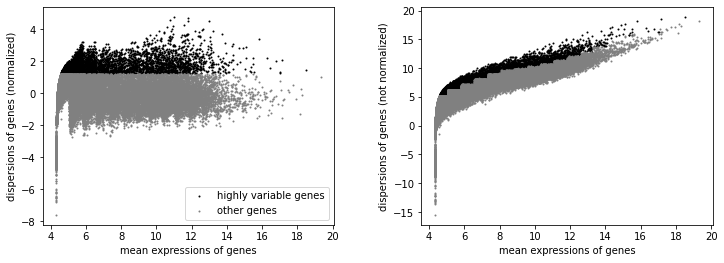

In [4]:
sc.pp.highly_variable_genes(primitive, n_top_genes=5000)
sc.pl.highly_variable_genes(primitive)
primitive = primitive[:,primitive.var.highly_variable]

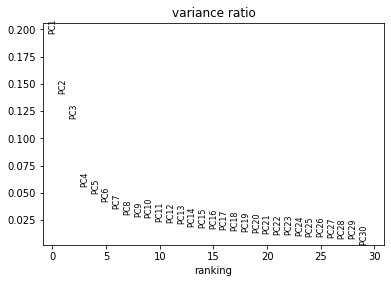

In [5]:
sc.pp.pca(primitive)
sc.pl.pca_variance_ratio(primitive)

... storing 'Hierarchy' as categorical
... storing 'NPM1c' as categorical
... storing 'FLT3-ITD' as categorical


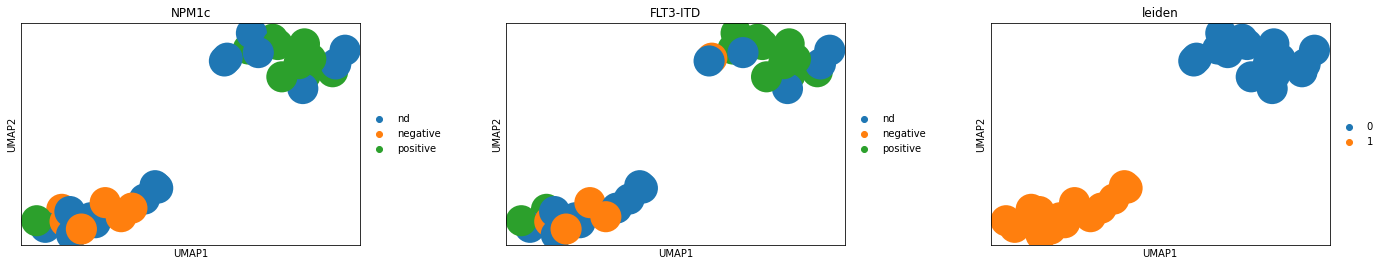

In [6]:
sc.pp.neighbors(primitive, n_neighbors=5)
sc.tl.umap(primitive, min_dist=0.1, spread=0.5)
sc.tl.leiden(primitive, resolution=0.3)
sc.pl.umap(primitive, color=['NPM1c', 'FLT3-ITD', 'leiden'], 
           wspace=0.3, ncols=3, cmap='RdBu_r', vmin='p5', vmax='p95')

**This does not perfectly separate samples based on NPM1c. Retry with NPM1c-specific genes**

In [7]:
response_pts = ['90185', '90428', '90392', '90239', '110120', '100091', '120899', '110625', '110555', '110102', '90135', '120846', '110484', '5786', '140171', '120858', '140005']
primitive.obs['DrugResponse'] = np.where(primitive.obs['Patient'].isin(response_pts), 'DrugResponse', 'NA')

In [8]:
primitive_NPM1c_status = primitive[primitive.obs.NPM1c.isin(['positive', 'negative'])]

/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/pandas/core/arrays/categorical.py:2492: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


/Users/andyzeng/opt/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'DrugResponse' as categorical


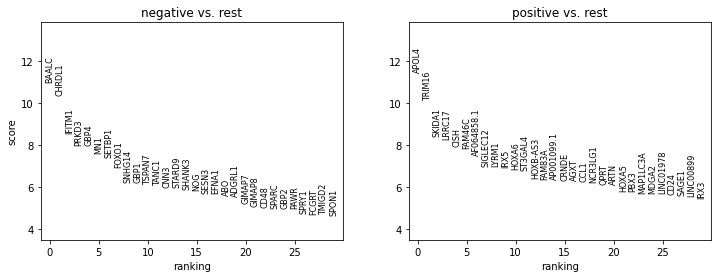

In [9]:
sc.tl.rank_genes_groups(primitive_NPM1c_status, 'NPM1c')
sc.pl.rank_genes_groups(primitive_NPM1c_status, n_genes=30)

In [10]:
npm1_genes = pd.DataFrame({'gene' : [x[1] for x in primitive_NPM1c_status.uns['rank_genes_groups']['names']],
                           'lfc' : [x[1] for x in primitive_NPM1c_status.uns['rank_genes_groups']['logfoldchanges']],
                           'padj' : [x[1] for x in primitive_NPM1c_status.uns['rank_genes_groups']['pvals_adj']]})
npm1_genes = npm1_genes[(npm1_genes['padj'] < 0.01) & (npm1_genes['lfc'] >= 1)]['gene']
npm1_genes

0          APOL4
1         TRIM16
2         SKIDA1
3         LRRC17
4           CISH
5         FAM46C
6     AF064858.1
7       SIGLEC12
8          LYRM1
9           IRX5
10         HOXA6
11       ST3GAL4
12      HOXB-AS3
13        FAM83A
14    AP001099.1
15         CRNDE
16          AGXT
17          CCL1
18       NCR3LG1
19          QPRT
20          ARTN
21         HOXA5
22          PBX3
23      MAP1LC3A
24         MDGA2
25     LINC01978
26          CD24
28     LINC00899
29          IRX3
30        BAHCC1
31         ENPP2
33         MAP1A
34         EPCAM
35          SMC4
36          MAOA
37        TRIM15
38         PCDH9
40         SCN2A
45        PIWIL4
Name: gene, dtype: object

## Clustering of Primitive AML samples using NPM1 DE Genes

In [716]:
primitive_npm1genes = primitive[:,primitive.var_names.isin(npm1_genes)]
primitive_npm1genes

View of AnnData object with n_obs × n_vars = 31 × 39
    obs: 'Patient', 'Hierarchy', 'NPM1c', 'FLT3-ITD', 'leiden', 'DrugResponse'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'umap', 'leiden', 'NPM1c_colors', 'FLT3-ITD_colors', 'leiden_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [717]:
sc.pp.pca(primitive_npm1genes)
sc.pp.neighbors(primitive_npm1genes, n_neighbors=5)
sc.tl.umap(primitive_npm1genes, min_dist=0.1, spread=1)
sc.tl.leiden(primitive_npm1genes, resolution=0.25)

... storing 'DrugResponse' as categorical


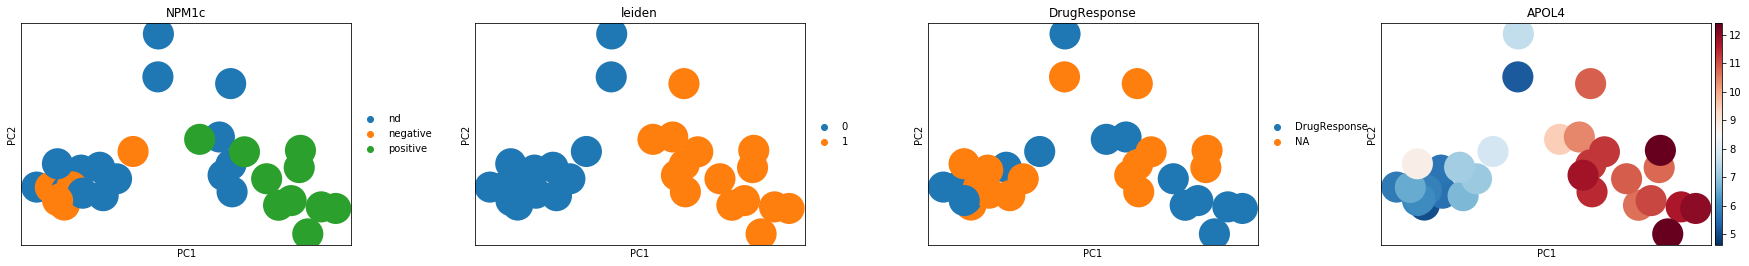

In [718]:
sc.pl.pca(primitive_npm1genes, color=['NPM1c', 'leiden', 'DrugResponse', 'APOL4'], wspace=0.25, cmap='RdBu_r')

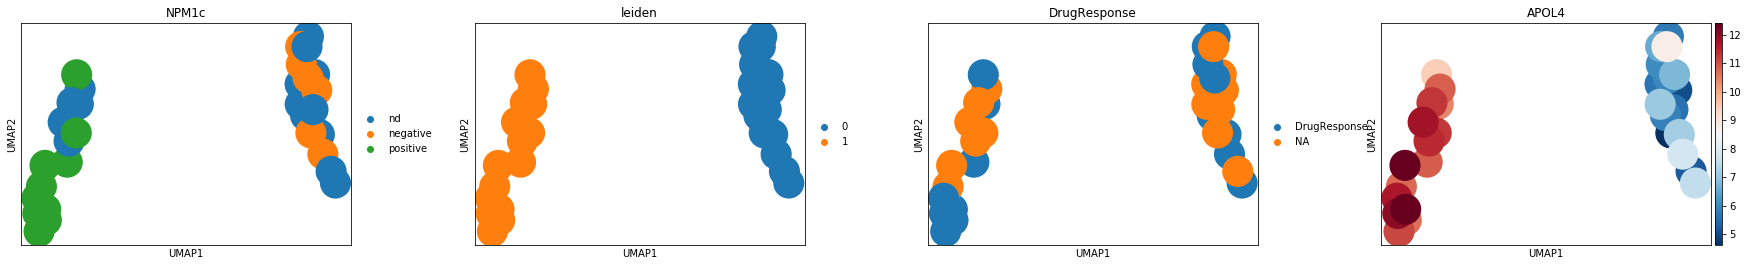

In [719]:
sc.pl.umap(primitive_npm1genes, color=['NPM1c', 'leiden', 'DrugResponse', 'APOL4'], wspace=0.25, cmap='RdBu_r')

... storing 'Cluster' as categorical


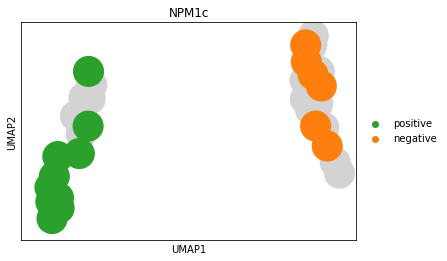

In [724]:
sc.pl.umap(primitive_npm1genes, color=['NPM1c'], wspace=0.25, cmap='RdBu_r', groups=['positive', 'negative'])

In [720]:
primitive_npm1genes.obs['Cluster'] = np.where(primitive_npm1genes.obs['leiden'] == '1', 'Primitive NPM1', 'Primitive Other')
primitive_npm1genes.obs['Cluster']

CC01               Primitive Other
CC02               Primitive Other
CC03               Primitive Other
CC04                Primitive NPM1
CC10                Primitive NPM1
CC11               Primitive Other
CC15                Primitive NPM1
CC20                Primitive NPM1
CC26                Primitive NPM1
CC29                Primitive NPM1
CC30               Primitive Other
CC31                Primitive NPM1
LSC0008_Bl_Bulk    Primitive Other
LSC0012_Bl_Bulk     Primitive NPM1
LSC0013_Bl_Bulk    Primitive Other
LSC0018_Bl_Bulk    Primitive Other
LSC0022_Bl_Bulk     Primitive NPM1
LSC0027_Bl_Bulk     Primitive NPM1
LSC0030_Bl_Bulk    Primitive Other
LSC0036_Bl_Bulk    Primitive Other
LSC0038_Bl_Bulk     Primitive NPM1
LSC0039_Bl_Bulk     Primitive NPM1
LSC0040_Bl_Bulk    Primitive Other
LSC0056_Bl_Bulk    Primitive Other
LSC0057_Bl_Bulk    Primitive Other
LSC0058_Bl_Bulk     Primitive NPM1
LSC0060_Bl_Bulk    Primitive Other
LSC0061_Bl_Bulk    Primitive Other
LSC0065_Bl_Bulk     